In [ ]:
#ML_Project

In [1]:
# === IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# === LOAD DATA ===
print("Loading California Housing Dataset...")
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = list(housing.feature_names)

# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("\nCalifornia Housing Dataset loaded successfully!")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Features: {feature_names}")
print(f"\nTarget variable (median house value) range: ${y.min():.2f}00k - ${y.max():.2f}00k")

# All features are numerical in California Housing
numerical_features = feature_names
categorical_features = []  # No categorical features in this dataset

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Loading California Housing Dataset...

California Housing Dataset loaded successfully!
Shape of X: (20640, 8)
Shape of y: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target variable (median house value) range: $0.1500k - $5.0000k

Numerical features: 8
Categorical features: 0


In [2]:
# === EXPLORATORY DATA ANALYSIS ===
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic statistics
print("\nDataset Statistics:")
print(df.describe().round(3))

# Checking for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Checking target distribution statistics
print(f"\nTarget Variable Statistics:")
print(f"  Mean: ${y.mean():.3f}00k")
print(f"  Std:  ${y.std():.3f}00k")
print(f"  Min:  ${y.min():.3f}00k")
print(f"  Max:  ${y.max():.3f}00k")

# Checking for outliers using IQR method
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['target'] < Q1 - 1.5 * IQR) | (df['target'] > Q3 + 1.5 * IQR)]
print(f"\nOutliers in target variable: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

# Feature correlations with target
correlations = df.corr()['target'].sort_values(ascending=False)
print("\nFeature Correlations with Target:")
for feat, corr in correlations[1:].items():  # Skip target itself
    print(f"  {feat}: {corr:.3f}")

# Checking data distributions
print("\nFeature Distributions (Skewness):")
for col in feature_names:
    skewness = df[col].skew()
    print(f"  {col}: {skewness:.3f}")


EXPLORATORY DATA ANALYSIS

Dataset Statistics:
          MedInc   HouseAge   AveRooms  AveBedrms  Population   AveOccup  \
count  20640.000  20640.000  20640.000  20640.000   20640.000  20640.000   
mean       3.871     28.639      5.429      1.097    1425.477      3.071   
std        1.900     12.586      2.474      0.474    1132.462     10.386   
min        0.500      1.000      0.846      0.333       3.000      0.692   
25%        2.563     18.000      4.441      1.006     787.000      2.430   
50%        3.535     29.000      5.229      1.049    1166.000      2.818   
75%        4.743     37.000      6.052      1.100    1725.000      3.282   
max       15.000     52.000    141.909     34.067   35682.000   1243.333   

        Latitude  Longitude     target  
count  20640.000  20640.000  20640.000  
mean      35.632   -119.570      2.069  
std        2.136      2.004      1.154  
min       32.540   -124.350      0.150  
25%       33.930   -121.800      1.196  
50%       34.260   -1


Generating EDA visualizations...


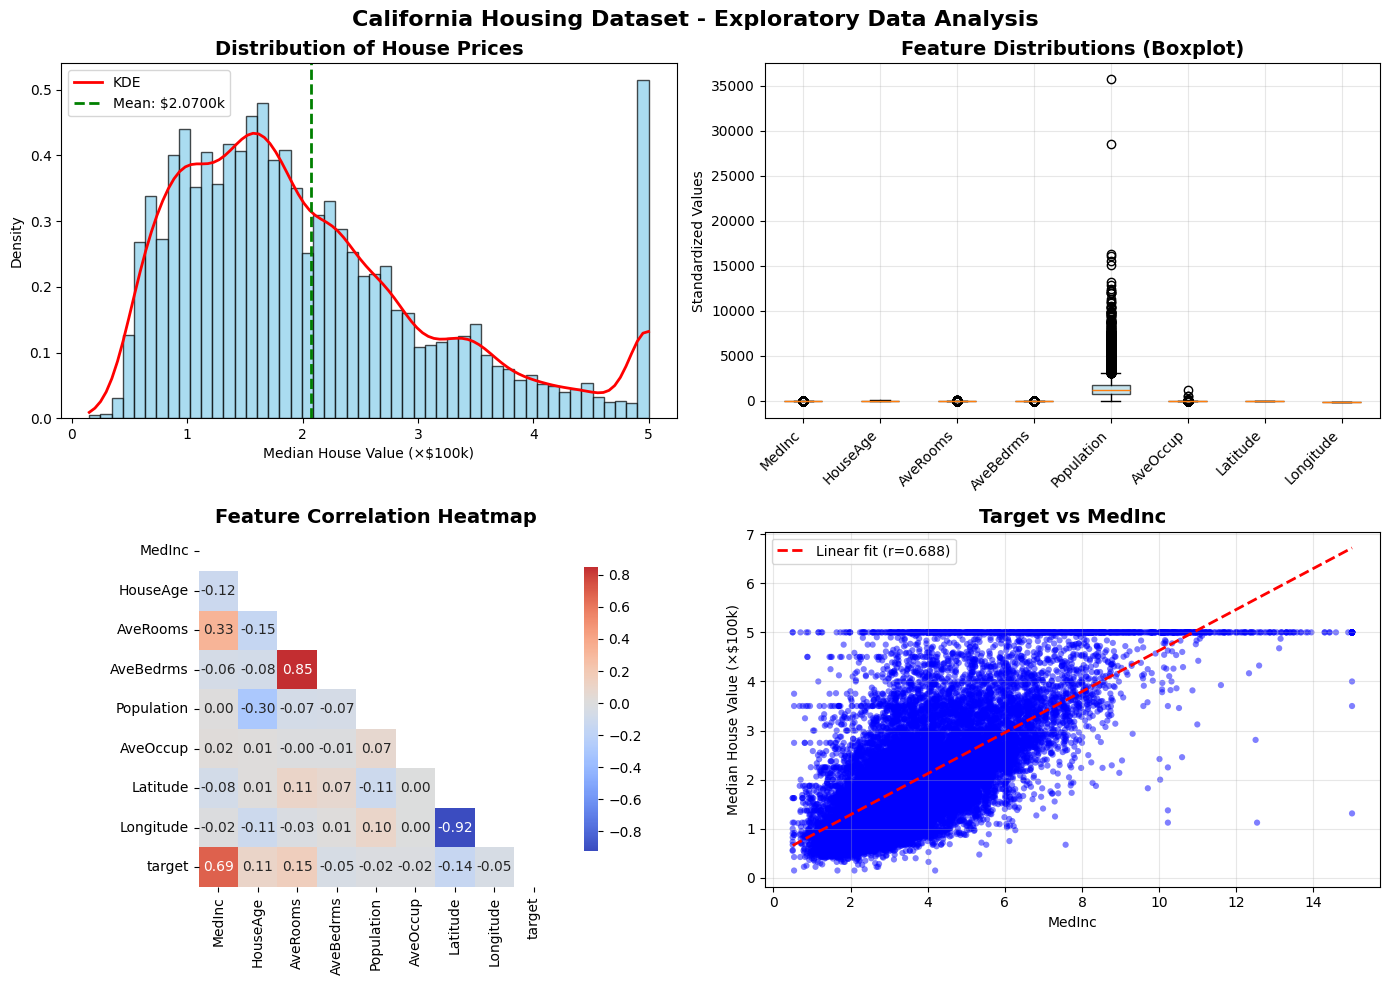

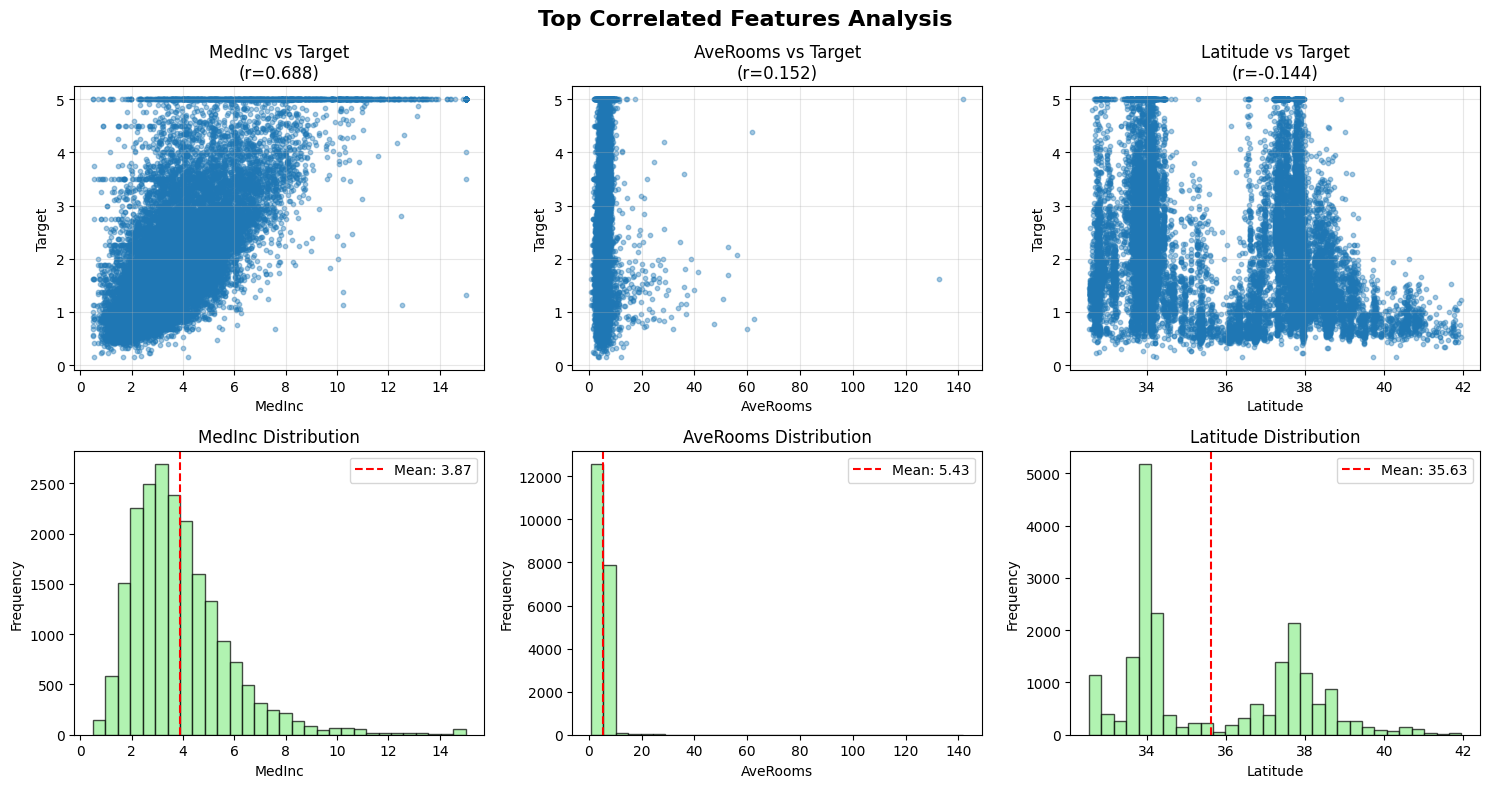


EDA visualizations completed.


In [4]:
# === EDA VISUALIZATIONS ===
print("\nGenerating EDA visualizations...")

# Calculating correlation matrix first
correlation_matrix = df.corr()

# Figure 1: Main distributions and relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Target distribution with KDE
axes[0, 0].hist(y, bins=50, edgecolor='black', alpha=0.7, color='skyblue', density=True)
axes[0, 0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Median House Value (×$100k)')
axes[0, 0].set_ylabel('Density')
# Adding KDE line
from scipy.stats import gaussian_kde
kde = gaussian_kde(y)
x_range = np.linspace(y.min(), y.max(), 100)
axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0, 0].axvline(y.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: ${y.mean():.2f}00k')
axes[0, 0].legend()

# Feature distributions boxplot with better styling
bp = axes[0, 1].boxplot(X, labels=feature_names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
axes[0, 1].set_title('Feature Distributions (Boxplot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(feature_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Standardized Values')
axes[0, 1].grid(True, alpha=0.3)

# Enhanced correlation heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            ax=axes[1, 0], fmt='.2f', square=True, cbar_kws={"shrink": .8})
axes[1, 0].set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# Target vs most correlated feature with regression line
most_correlated_feature = correlation_matrix['target'].abs().sort_values(ascending=False).index[1]
corr_value = correlation_matrix['target'][most_correlated_feature]
axes[1, 1].scatter(df[most_correlated_feature], df['target'], alpha=0.5, s=20, c='blue', edgecolors='none')
# Adding regression line
z = np.polyfit(df[most_correlated_feature], df['target'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df[most_correlated_feature].sort_values(),
                p(df[most_correlated_feature].sort_values()),
                "r--", linewidth=2, label=f'Linear fit (r={corr_value:.3f})')
axes[1, 1].set_xlabel(most_correlated_feature)
axes[1, 1].set_ylabel('Median House Value (×$100k)')
axes[1, 1].set_title(f'Target vs {most_correlated_feature}', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('California Housing Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Figure 2: Additional feature analysis
fig2, axes2 = plt.subplots(2, 3, figsize=(15, 8))

# Top 3 correlated features scatter plots
top_3_features = correlation_matrix['target'].abs().sort_values(ascending=False).index[1:4]
for idx, feature in enumerate(top_3_features):
    axes2[0, idx].scatter(df[feature], df['target'], alpha=0.4, s=10)
    axes2[0, idx].set_xlabel(feature)
    axes2[0, idx].set_ylabel('Target')
    axes2[0, idx].set_title(f'{feature} vs Target\n(r={correlation_matrix["target"][feature]:.3f})')
    axes2[0, idx].grid(True, alpha=0.3)

# Feature distributions (histograms) for top 3
for idx, feature in enumerate(top_3_features):
    axes2[1, idx].hist(df[feature], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes2[1, idx].set_xlabel(feature)
    axes2[1, idx].set_ylabel('Frequency')
    axes2[1, idx].set_title(f'{feature} Distribution')
    axes2[1, idx].axvline(df[feature].mean(), color='red', linestyle='--',
                         label=f'Mean: {df[feature].mean():.2f}')
    axes2[1, idx].legend()

plt.suptitle('Top Correlated Features Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEDA visualizations completed.")

In [11]:
# === PREPROCESSING AND MODEL PIPELINES ===

# Getting column indices instead of names for numpy array
numerical_indices = list(range(len(feature_names)))  # [0, 1, 2, 3, 4, 5, 6, 7]

# Since California Housing has only numerical features
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Preprocessor using column indices
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_indices)
])

# Creating model pipelines
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))
])

svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(C=1.0, epsilon=0.1, kernel='rbf'))
])

# === MODEL DICTIONARY ===
models = {
    'Linear Regression': lr_pipeline,
    'Ridge Regression': ridge_pipeline,
    'Decision Tree': dt_pipeline,
    'Random Forest': rf_pipeline,
    'SVR': svr_pipeline
}

# === 5-FOLD CROSS-VALIDATION ===
print("\n" + "="*60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("="*60)

cv_results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, pipeline in models.items():
    print(f"\nEvaluating {model_name}...")
    start_time = time.time()

    # Using sklearn's cross_val_score for multiple metrics
    scores_r2 = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
    scores_mse = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    scores_mae = -cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

    cv_time = time.time() - start_time

    cv_results[model_name] = {
        'r2_scores': scores_r2,
        'mse_scores': scores_mse,
        'mae_scores': scores_mae,
        'r2_mean': np.mean(scores_r2),
        'r2_std': np.std(scores_r2),
        'mse_mean': np.mean(scores_mse),
        'mse_std': np.std(scores_mse),
        'mae_mean': np.mean(scores_mae),
        'mae_std': np.std(scores_mae),
        'cv_time': cv_time
    }

    print(f"  R² scores: {scores_r2}")
    print(f"  Mean R²: {cv_results[model_name]['r2_mean']:.4f} (±{cv_results[model_name]['r2_std']:.4f})")
    print(f"  Mean MSE: {cv_results[model_name]['mse_mean']:.4f} (±{cv_results[model_name]['mse_std']:.4f})")
    print(f"  Mean MAE: {cv_results[model_name]['mae_mean']:.4f} (±{cv_results[model_name]['mae_std']:.4f})")
    print(f"  CV Time: {cv_time:.2f} seconds")

# === STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*60)
print("PAIRED T-TESTS (vs Linear Regression)")
print("="*60)

lr_scores = cv_results['Linear Regression']['r2_scores']
for model_name in ['Ridge Regression', 'Decision Tree', 'Random Forest', 'SVR']:
    other_scores = cv_results[model_name]['r2_scores']
    t_stat, p_value = stats.ttest_rel(lr_scores, other_scores)
    print(f"\nLinear Regression vs {model_name}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4e}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")


5-FOLD CROSS-VALIDATION RESULTS

Evaluating Linear Regression...
  R² scores: [0.57578771 0.61374822 0.60856043 0.62126494 0.5875292 ]
  Mean R²: 0.6014 (±0.0170)
  Mean MSE: 0.5306 (±0.0218)
  Mean MAE: 0.5317 (±0.0084)
  CV Time: 2.21 seconds

Evaluating Ridge Regression...
  R² scores: [0.57581574 0.61374535 0.60854953 0.62126497 0.58752907]
  Mean R²: 0.6014 (±0.0170)
  Mean MSE: 0.5306 (±0.0218)
  Mean MAE: 0.5317 (±0.0084)
  CV Time: 0.49 seconds

Evaluating Decision Tree...
  R² scores: [0.68676881 0.70456747 0.69623095 0.71488283 0.6895124 ]
  Mean R²: 0.6984 (±0.0103)
  Mean MSE: 0.4014 (±0.0131)
  Mean MAE: 0.4229 (±0.0085)
  CV Time: 1.90 seconds

Evaluating Random Forest...
  R² scores: [0.7737926  0.78383768 0.7765964  0.79866133 0.77447872]
  Mean R²: 0.7815 (±0.0093)
  Mean MSE: 0.2909 (±0.0120)
  Mean MAE: 0.3657 (±0.0085)
  CV Time: 49.24 seconds

Evaluating SVR...
  R² scores: [0.72759085 0.74089052 0.73710577 0.77237261 0.73054481]
  Mean R²: 0.7417 (±0.0160)
  Mean


TRAIN-TEST SPLIT EVALUATION

Linear Regression:
  Training Metrics:
    R²: 0.6126, MSE: 0.5179, MAE: 0.5286
  Test Metrics:
    R²: 0.5758, MSE: 0.5559, MAE: 0.5332
  Training Time: 0.03 seconds

Ridge Regression:
  Training Metrics:
    R²: 0.6126, MSE: 0.5179, MAE: 0.5286
  Test Metrics:
    R²: 0.5758, MSE: 0.5559, MAE: 0.5332
  Training Time: 0.02 seconds

Decision Tree:
  Training Metrics:
    R²: 0.8324, MSE: 0.2240, MAE: 0.3237
  Test Metrics:
    R²: 0.6868, MSE: 0.4105, MAE: 0.4320
  Training Time: 0.22 seconds

Random Forest:
  Training Metrics:
    R²: 0.8723, MSE: 0.1708, MAE: 0.2917
  Test Metrics:
    R²: 0.7734, MSE: 0.2970, MAE: 0.3675
  Training Time: 3.31 seconds

SVR:
  Training Metrics:
    R²: 0.7486, MSE: 0.3361, MAE: 0.3831
  Test Metrics:
    R²: 0.7276, MSE: 0.3570, MAE: 0.3986
  Training Time: 21.38 seconds

MODEL PERFORMANCE SUMMARY
            Model  CV R²  Test R²  Test MSE  Test MAE  Test RMSE  Train Time (s)
Linear Regression 0.6014   0.5758    0.5559  

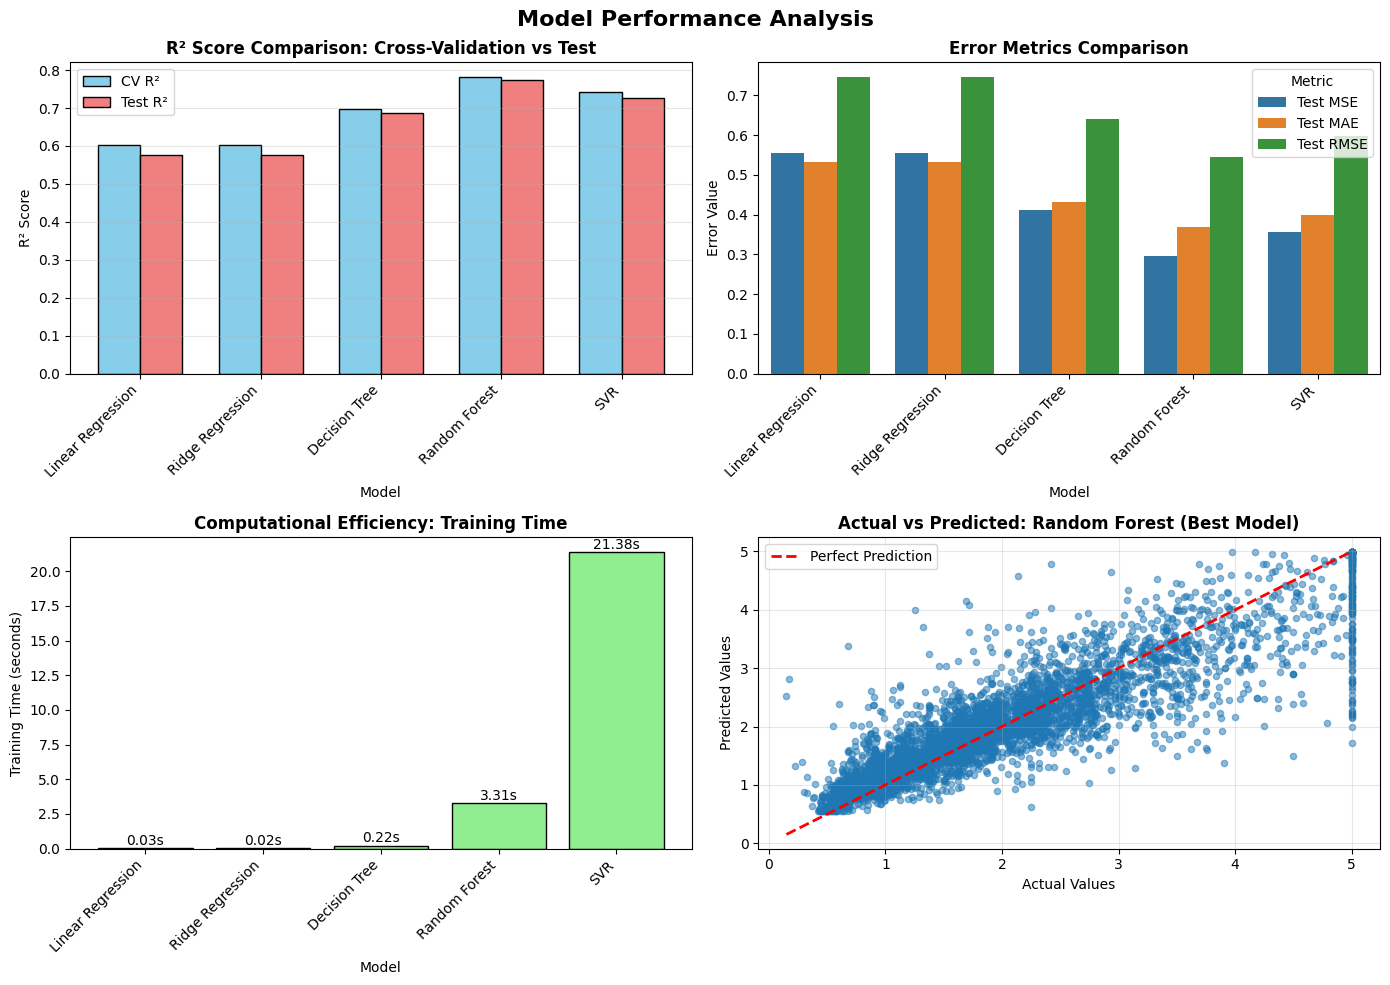

In [12]:
# === TRAIN-TEST SPLIT EVALUATION ===
print("\n" + "="*60)
print("TRAIN-TEST SPLIT EVALUATION")
print("="*60)

train_test_results = {}

for model_name, pipeline in models.items():
    print(f"\n{model_name}:")
    start_time = time.time()

    # Fitting the model
    pipeline.fit(X_train, y_train)

    # Making predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Calculating metrics
    train_metrics = evaluate_regression_model(y_train, y_pred_train)
    test_metrics = evaluate_regression_model(y_test, y_pred_test)

    train_time = time.time() - start_time

    # Storing results
    train_test_results[model_name] = {
        'train': train_metrics,
        'test': test_metrics,
        'train_time': train_time,
        'y_pred_test': y_pred_test
    }

    # Print results
    print(f"  Training Metrics:")
    print(f"    R²: {train_metrics['r2']:.4f}, MSE: {train_metrics['mse']:.4f}, MAE: {train_metrics['mae']:.4f}")
    print(f"  Test Metrics:")
    print(f"    R²: {test_metrics['r2']:.4f}, MSE: {test_metrics['mse']:.4f}, MAE: {test_metrics['mae']:.4f}")
    print(f"  Training Time: {train_time:.2f} seconds")

# === RESULTS SUMMARY DATAFRAME ===
summary_data = []
for model_name in models.keys():
    summary_data.append({
        'Model': model_name,
        'CV R²': cv_results[model_name]['r2_mean'],
        'Test R²': train_test_results[model_name]['test']['r2'],
        'Test MSE': train_test_results[model_name]['test']['mse'],
        'Test MAE': train_test_results[model_name]['test']['mae'],
        'Test RMSE': train_test_results[model_name]['test']['rmse'],
        'Train Time (s)': train_test_results[model_name]['train_time']
    })

results_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.round(4).to_string(index=False))

# === VISUALIZATION: MODEL COMPARISON ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. R² Score Comparison (CV vs Test)
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.35
ax1.bar(x - width/2, results_df['CV R²'], width, label='CV R²', color='skyblue', edgecolor='black')
ax1.bar(x + width/2, results_df['Test R²'], width, label='Test R²', color='lightcoral', edgecolor='black')
ax1.set_xlabel('Model')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score Comparison: Cross-Validation vs Test', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', alpha=0.3)

# 2. Error Metrics Comparison
ax2 = axes[0, 1]
metrics_df = results_df[['Model', 'Test MSE', 'Test MAE', 'Test RMSE']].melt(
    id_vars='Model', var_name='Metric', value_name='Value'
)
sns.barplot(data=metrics_df, x='Model', y='Value', hue='Metric', ax=ax2)
ax2.set_title('Error Metrics Comparison', fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Error Value')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')

# 3. Training Time Comparison
ax3 = axes[1, 0]
bars = ax3.bar(results_df['Model'], results_df['Train Time (s)'],
                color='lightgreen', edgecolor='black')
ax3.set_xlabel('Model')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Computational Efficiency: Training Time', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), ha='right')
for bar, time in zip(bars, results_df['Train Time (s)']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time:.2f}s', ha='center', va='bottom')

# 4. Actual vs Predicted (Best Model)
ax4 = axes[1, 1]
best_model = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
y_pred_best = train_test_results[best_model]['y_pred_test']
ax4.scatter(y_test, y_pred_best, alpha=0.5, s=20)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Values')
ax4.set_ylabel('Predicted Values')
ax4.set_title(f'Actual vs Predicted: {best_model} (Best Model)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS

Linear Regression - Top 5 Features:
  Feature  Importance             Model
 Latitude    0.896929 Linear Regression
Longitude    0.869842 Linear Regression
   MedInc    0.854383 Linear Regression
AveBedrms    0.339259 Linear Regression
 AveRooms    0.294410 Linear Regression

Ridge Regression - Top 5 Features:
  Feature  Importance            Model
 Latitude    0.896168 Ridge Regression
Longitude    0.869071 Ridge Regression
   MedInc    0.854327 Ridge Regression
AveBedrms    0.339008 Ridge Regression
 AveRooms    0.294210 Ridge Regression

Decision Tree - Top 5 Features:
  Feature  Importance         Model
   MedInc    0.610790 Decision Tree
 AveOccup    0.130952 Decision Tree
 Latitude    0.080471 Decision Tree
Longitude    0.066033 Decision Tree
 HouseAge    0.044509 Decision Tree

Random Forest - Top 5 Features:
  Feature  Importance         Model
   MedInc    0.593917 Random Forest
 AveOccup    0.139128 Random Forest
 Latitude    0.076906 Random Fores

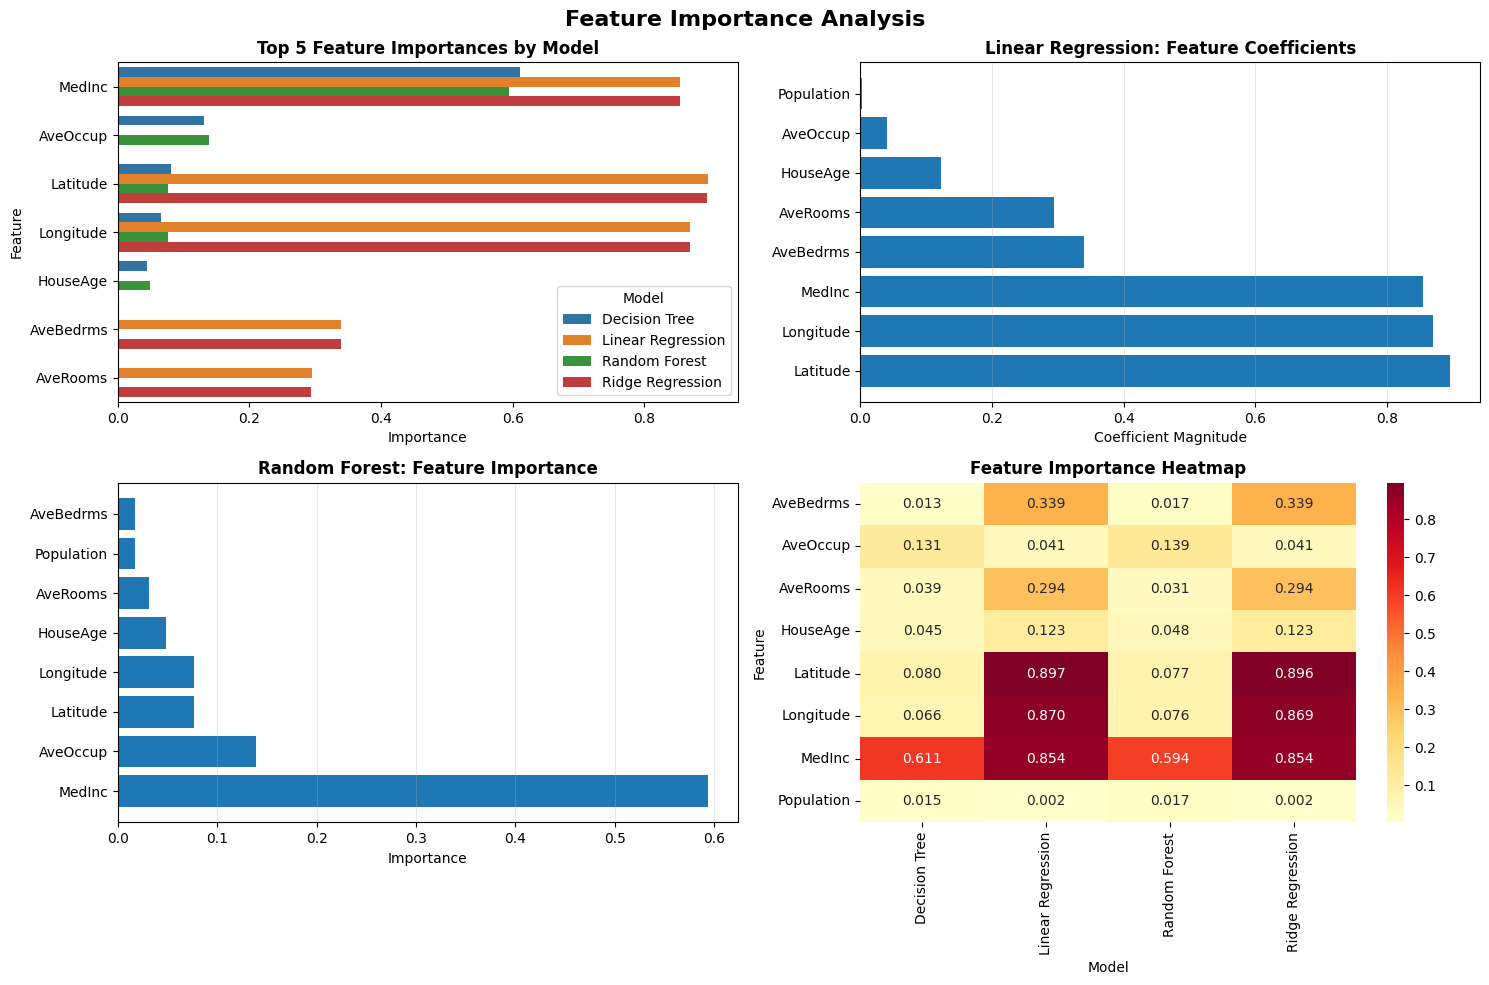


FEATURE ABLATION STUDY

Linear Regression - Dropping top 2 features: ['Latitude', 'Longitude']
  Original R²: 0.5758
  Ablated R²: 0.5099
  Performance drop: 11.44%

Ridge Regression - Dropping top 2 features: ['Latitude', 'Longitude']
  Original R²: 0.5758
  Ablated R²: 0.5100
  Performance drop: 11.44%

Decision Tree - Dropping top 2 features: ['MedInc', 'AveOccup']
  Original R²: 0.6868
  Ablated R²: 0.7132
  Performance drop: -3.85%

Random Forest - Dropping top 2 features: ['MedInc', 'AveOccup']
  Original R²: 0.7734
  Ablated R²: 0.7791
  Performance drop: -0.74%


In [13]:
# === FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

def get_feature_importance(pipeline, model_name):
    """Extract feature importance/coefficients from fitted models"""
    model = pipeline.named_steps['regressor']

    if hasattr(model, 'coef_'):  # Linear models
        importances = np.abs(model.coef_)
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        importances = model.feature_importances_
    else:
        return None

    # Creating DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Model': model_name
    })
    return importance_df.sort_values('Importance', ascending=False)

# Collecting feature importances
all_importances = []
for model_name in ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest']:
    if model_name in models:
        importance_df = get_feature_importance(models[model_name], model_name)
        if importance_df is not None:
            all_importances.append(importance_df)
            print(f"\n{model_name} - Top 5 Features:")
            print(importance_df.head().to_string(index=False))

# Combining all importances
combined_importances = pd.concat(all_importances, ignore_index=True)

# === VISUALIZATION: FEATURE IMPORTANCE ===
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Top 5 features per model
ax1 = axes[0, 0]
top_features = combined_importances.groupby('Model').apply(
    lambda x: x.nlargest(5, 'Importance')
).reset_index(drop=True)
sns.barplot(data=top_features, x='Importance', y='Feature', hue='Model', ax=ax1)
ax1.set_title('Top 5 Feature Importances by Model', fontweight='bold')
ax1.set_xlabel('Importance')

# Plot 2: Linear Regression Coefficients
ax2 = axes[0, 1]
lr_importance = combined_importances[combined_importances['Model'] == 'Linear Regression']
bars = ax2.barh(lr_importance['Feature'], lr_importance['Importance'])
ax2.set_xlabel('Coefficient Magnitude')
ax2.set_title('Linear Regression: Feature Coefficients', fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

# Plot 3: Random Forest Feature Importance
ax3 = axes[1, 0]
rf_importance = combined_importances[combined_importances['Model'] == 'Random Forest']
bars = ax3.barh(rf_importance['Feature'], rf_importance['Importance'])
ax3.set_xlabel('Importance')
ax3.set_title('Random Forest: Feature Importance', fontweight='bold')
ax3.grid(True, axis='x', alpha=0.3)

# Plot 4: Feature Importance Heatmap
ax4 = axes[1, 1]
importance_pivot = combined_importances.pivot(index='Feature', columns='Model', values='Importance')
sns.heatmap(importance_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Feature Importance Heatmap', fontweight='bold')

plt.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# === FEATURE ABLATION STUDY ===
print("\n" + "="*60)
print("FEATURE ABLATION STUDY")
print("="*60)

# Getting top 2 features for each model
ablation_results = {}

for model_name in ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest']:
    if model_name not in models:
        continue

    # Getting feature importance
    importance_df = get_feature_importance(models[model_name], model_name)
    if importance_df is None:
        continue

    # Getting top 2 features
    top_2_features = importance_df.head(2)['Feature'].tolist()
    top_2_indices = [feature_names.index(feat) for feat in top_2_features]

    print(f"\n{model_name} - Dropping top 2 features: {top_2_features}")

    # Create mask for features to keep
    features_to_keep = [i for i in range(len(feature_names)) if i not in top_2_indices]

    # Create new data without top features
    X_ablated = X[:, features_to_keep]
    X_train_ablated = X_train[:, features_to_keep]
    X_test_ablated = X_test[:, features_to_keep]

    # Create new preprocessor for ablated data
    preprocessor_ablated = ColumnTransformer([
        ('num', StandardScaler(), list(range(len(features_to_keep))))
    ])

    # Create new pipeline
    if 'Linear' in model_name:
        model_ablated = Pipeline([
            ('preprocessor', preprocessor_ablated),
            ('regressor', LinearRegression())
        ])
    elif 'Ridge' in model_name:
        model_ablated = Pipeline([
            ('preprocessor', preprocessor_ablated),
            ('regressor', Ridge(alpha=1.0))
        ])
    elif 'Decision Tree' in model_name:
        model_ablated = Pipeline([
            ('preprocessor', preprocessor_ablated),
            ('regressor', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42))
        ])
    elif 'Random Forest' in model_name:
        model_ablated = Pipeline([
            ('preprocessor', preprocessor_ablated),
            ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42))
        ])

    # Training and evaluate
    model_ablated.fit(X_train_ablated, y_train)
    y_pred_ablated = model_ablated.predict(X_test_ablated)
    r2_ablated = r2_score(y_test, y_pred_ablated)

    # Comparing with original
    original_r2 = train_test_results[model_name]['test']['r2']
    drop_percentage = ((original_r2 - r2_ablated) / original_r2) * 100

    ablation_results[model_name] = {
        'dropped_features': top_2_features,
        'original_r2': original_r2,
        'ablated_r2': r2_ablated,
        'performance_drop': drop_percentage
    }

    print(f"  Original R²: {original_r2:.4f}")
    print(f"  Ablated R²: {r2_ablated:.4f}")
    print(f"  Performance drop: {drop_percentage:.2f}%")


LEARNING CURVES ANALYSIS

Training with 25% of data...

Training with 50% of data...

Training with 75% of data...

Training with 100% of data...


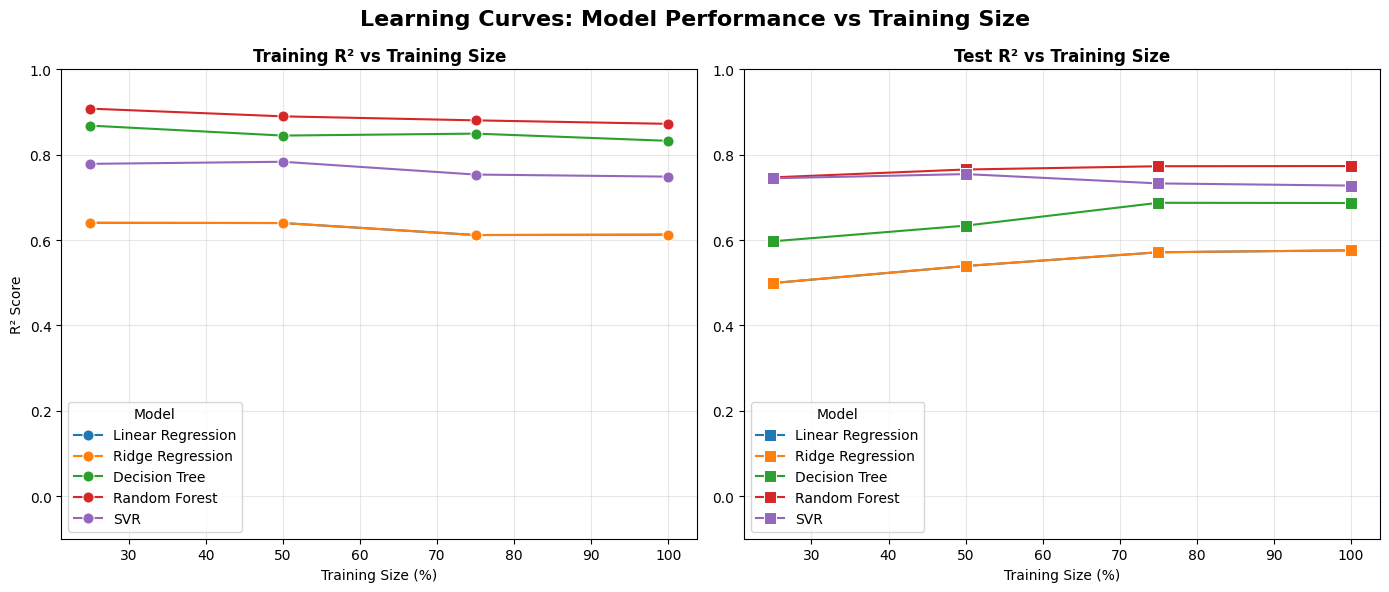


HYPERPARAMETER SENSITIVITY ANALYSIS

Ridge Regression - Testing alpha values...

Decision Tree - Testing max_depth and min_samples_split...

Random Forest - Testing n_estimators and max_depth...

SVR - Testing C and gamma values...


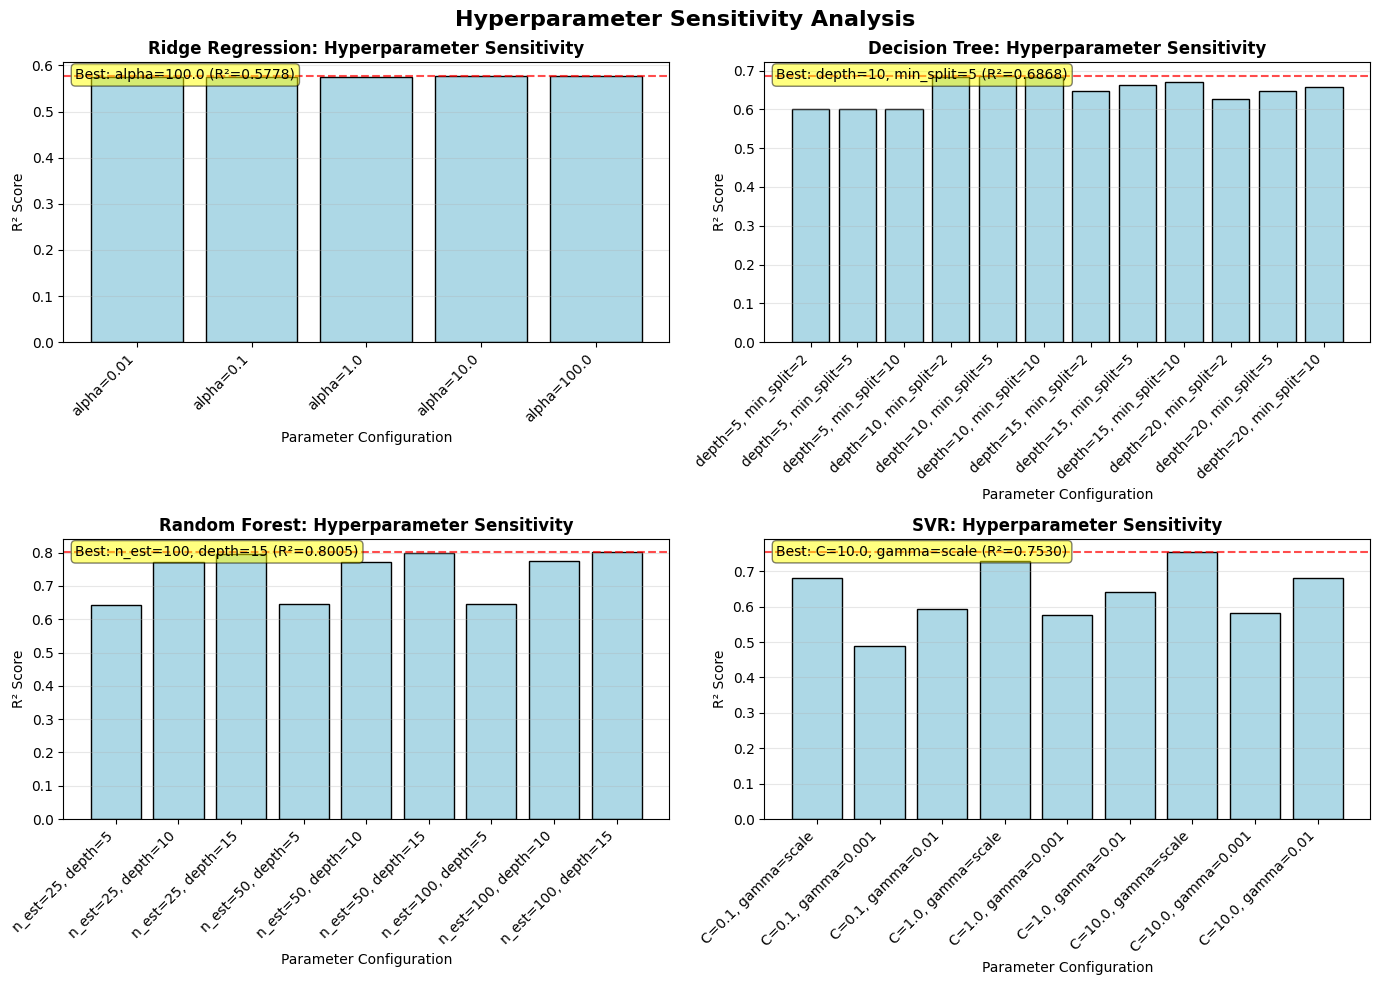


BEST HYPERPARAMETERS

Ridge Regression:
  Best parameters: alpha=100.0
  Best R² score: 0.5778

Decision Tree:
  Best parameters: depth=10, min_split=5
  Best R² score: 0.6868

Random Forest:
  Best parameters: n_est=100, depth=15
  Best R² score: 0.8005

SVR:
  Best parameters: C=10.0, gamma=scale
  Best R² score: 0.7530


In [14]:
# === LEARNING CURVES ===
print("\n" + "="*60)
print("LEARNING CURVES ANALYSIS")
print("="*60)

fractions = [0.25, 0.5, 0.75, 1.0]
learning_curve_results = {model: {'train': [], 'test': []} for model in models.keys()}

for frac in fractions:
    print(f"\nTraining with {int(frac*100)}% of data...")

    if frac < 1.0:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)
    else:
        X_frac, y_frac = X_train, y_train

    for model_name, pipeline in models.items():
        # Cloning the pipeline to avoid fitting issues
        from sklearn.base import clone
        model_clone = clone(pipeline)

        # Fitting on fraction of data
        model_clone.fit(X_frac, y_frac)

        # Evaluating on both train and test
        train_score = model_clone.score(X_frac, y_frac)
        test_score = model_clone.score(X_test, y_test)

        learning_curve_results[model_name]['train'].append((int(frac*100), train_score))
        learning_curve_results[model_name]['test'].append((int(frac*100), test_score))

# Converting to DataFrames for plotting
train_data = []
test_data = []
for model_name, scores in learning_curve_results.items():
    for size, score in scores['train']:
        train_data.append({'Model': model_name, 'TrainSize': size, 'R2': score})
    for size, score in scores['test']:
        test_data.append({'Model': model_name, 'TrainSize': size, 'R2': score})

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Plotting Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Training scores
sns.lineplot(data=df_train, x='TrainSize', y='R2', hue='Model',
             marker='o', markersize=8, ax=axes[0])
axes[0].set_title('Training R² vs Training Size', fontweight='bold')
axes[0].set_xlabel('Training Size (%)')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.0)

# Test scores
sns.lineplot(data=df_test, x='TrainSize', y='R2', hue='Model',
             marker='s', markersize=8, ax=axes[1])
axes[1].set_title('Test R² vs Training Size', fontweight='bold')
axes[1].set_xlabel('Training Size (%)')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelleft=True)

plt.suptitle('Learning Curves: Model Performance vs Training Size', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# === HYPERPARAMETER SENSITIVITY ANALYSIS ===
print("\n" + "="*60)
print("HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*60)

hyperparam_results = []

# Ridge Regression: alpha
print("\nRidge Regression - Testing alpha values...")
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
for alpha in alphas:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=alpha, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    hyperparam_results.append({
        'Model': 'Ridge Regression',
        'Parameter': f'alpha={alpha}',
        'R2': score
    })

# Decision Tree: max_depth and min_samples_split
print("\nDecision Tree - Testing max_depth and min_samples_split...")
for depth in [5, 10, 15, 20]:
    for min_split in [2, 5, 10]:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', DecisionTreeRegressor(max_depth=depth, min_samples_split=min_split, random_state=42))
        ])
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        hyperparam_results.append({
            'Model': 'Decision Tree',
            'Parameter': f'depth={depth}, min_split={min_split}',
            'R2': score
        })

# Random Forest: n_estimators and max_depth
print("\nRandom Forest - Testing n_estimators and max_depth...")
for n_est in [25, 50, 100]:
    for depth in [5, 10, 15]:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=42, n_jobs=-1))
        ])
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        hyperparam_results.append({
            'Model': 'Random Forest',
            'Parameter': f'n_est={n_est}, depth={depth}',
            'R2': score
        })

# SVR: C and gamma
print("\nSVR - Testing C and gamma values...")
for C in [0.1, 1.0, 10.0]:
    for gamma in ['scale', 0.001, 0.01]:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', SVR(C=C, gamma=gamma, kernel='rbf'))
        ])
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        hyperparam_results.append({
            'Model': 'SVR',
            'Parameter': f'C={C}, gamma={gamma}',
            'R2': score
        })

# Converting to DataFrame
hyperparam_df = pd.DataFrame(hyperparam_results)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
models_to_plot = ['Ridge Regression', 'Decision Tree', 'Random Forest', 'SVR']

for idx, model in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]
    model_data = hyperparam_df[hyperparam_df['Model'] == model]

    # Creating bar plot
    ax.bar(range(len(model_data)), model_data['R2'], color='lightblue', edgecolor='black')
    ax.set_xlabel('Parameter Configuration')
    ax.set_ylabel('R² Score')
    ax.set_title(f'{model}: Hyperparameter Sensitivity', fontweight='bold')
    ax.set_xticks(range(len(model_data)))
    ax.set_xticklabels(model_data['Parameter'], rotation=45, ha='right')
    ax.grid(True, axis='y', alpha=0.3)

    # Highlighing best configuration
    best_idx = model_data['R2'].idxmax()
    best_params = model_data.loc[best_idx, 'Parameter']
    best_score = model_data.loc[best_idx, 'R2']
    ax.axhline(y=best_score, color='red', linestyle='--', alpha=0.7)
    ax.text(0.02, 0.98, f'Best: {best_params} (R²={best_score:.4f})',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Hyperparameter Sensitivity Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Printing best hyperparameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
for model in models_to_plot:
    model_data = hyperparam_df[hyperparam_df['Model'] == model]
    best_idx = model_data['R2'].idxmax()
    print(f"\n{model}:")
    print(f"  Best parameters: {model_data.loc[best_idx, 'Parameter']}")
    print(f"  Best R² score: {model_data.loc[best_idx, 'R2']:.4f}")


NOISE ROBUSTNESS TESTING

Testing with noise level σ = 0.1...
  Linear Regression: R² = 0.5644 (drop: 1.98%)
  Ridge Regression: R² = 0.5644 (drop: 1.98%)
  Decision Tree: R² = 0.5394 (drop: 21.46%)
  Random Forest: R² = 0.6512 (drop: 15.80%)
  SVR: R² = 0.6621 (drop: 9.00%)

Testing with noise level σ = 0.2...
  Linear Regression: R² = 0.5343 (drop: 7.20%)
  Ridge Regression: R² = 0.5343 (drop: 7.20%)
  Decision Tree: R² = 0.4759 (drop: 30.71%)
  Random Forest: R² = 0.5953 (drop: 23.02%)
  SVR: R² = 0.5981 (drop: 17.80%)

Testing with noise level σ = 0.3...
  Linear Regression: R² = 0.4928 (drop: 14.41%)
  Ridge Regression: R² = 0.4928 (drop: 14.41%)
  Decision Tree: R² = 0.4368 (drop: 36.40%)
  Random Forest: R² = 0.5385 (drop: 30.37%)
  SVR: R² = 0.5344 (drop: 26.55%)

TRAINING SIZE SENSITIVITY

Training with 10% of data...

Training with 25% of data...

Training with 50% of data...

Training with 75% of data...

Training with 100% of data...


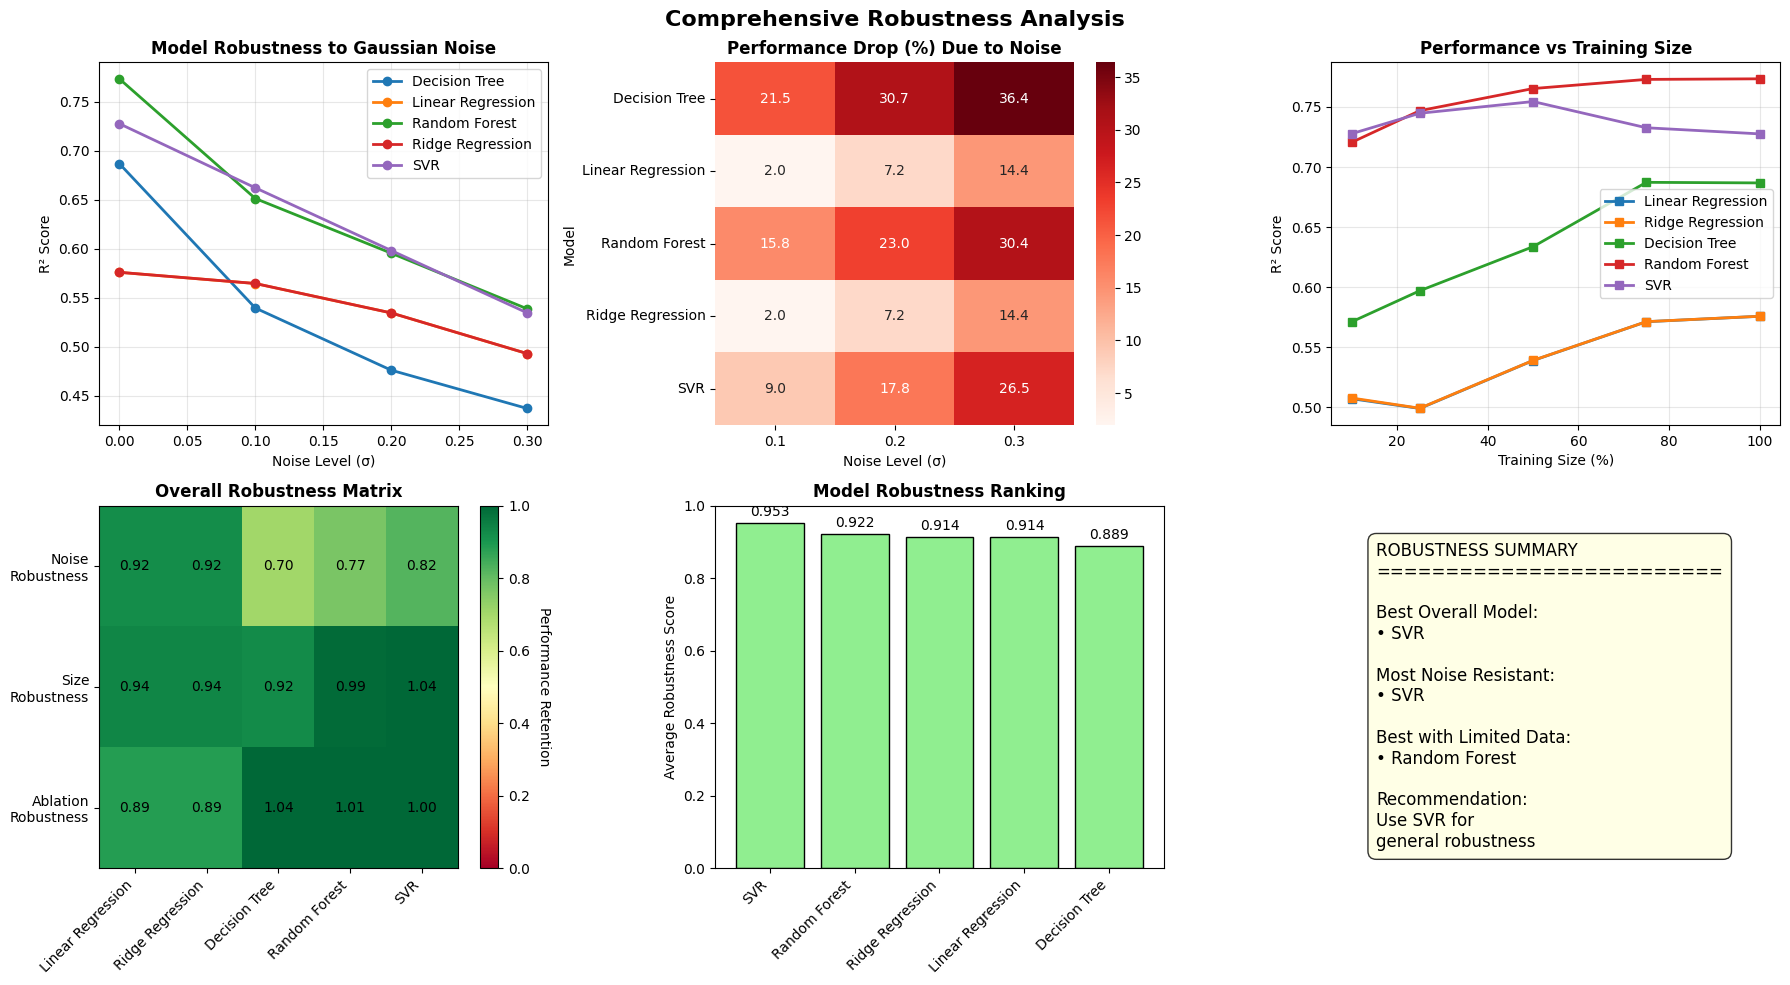


ROBUSTNESS ANALYSIS SUMMARY

Model Rankings (by average robustness):
  5. SVR: 0.953
  4. Random Forest: 0.922
  2. Ridge Regression: 0.914
  1. Linear Regression: 0.914
  3. Decision Tree: 0.889


In [15]:
# === NOISE ROBUSTNESS TESTING ===
print("\n" + "="*60)
print("NOISE ROBUSTNESS TESTING")
print("="*60)

def add_gaussian_noise(X, noise_level):
    """Add Gaussian noise to features"""
    noise = np.random.normal(0, noise_level * X.std(axis=0), X.shape)
    return X + noise

noise_levels = [0.1, 0.2, 0.3]
noise_results = []

for sigma in noise_levels:
    print(f"\nTesting with noise level σ = {sigma}...")

    # Adding noise to data
    X_noisy = add_gaussian_noise(X, sigma)
    X_train_noisy, X_test_noisy, _, _ = train_test_split(
        X_noisy, y, test_size=0.2, random_state=42
    )

    for model_name, pipeline in models.items():
        # Cloning and train on noisy data
        model_clone = clone(pipeline)
        model_clone.fit(X_train_noisy, y_train)

        # Evaluating on noisy test data
        score = model_clone.score(X_test_noisy, y_test)

        # Calculating performance drop
        original_score = train_test_results[model_name]['test']['r2']
        drop = ((original_score - score) / original_score) * 100

        noise_results.append({
            'Model': model_name,
            'Noise_Level': sigma,
            'R2': score,
            'Performance_Drop': drop
        })

        print(f"  {model_name}: R² = {score:.4f} (drop: {drop:.2f}%)")

# Converting to DataFrame
noise_df = pd.DataFrame(noise_results)

# === TRAINING SIZE SENSITIVITY (EXTENDED) ===
print("\n" + "="*60)
print("TRAINING SIZE SENSITIVITY")
print("="*60)

training_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
size_results = []

for size in training_sizes:
    print(f"\nTraining with {int(size*100)}% of data...")

    if size < 1.0:
        X_subset, _, y_subset, _ = train_test_split(
            X_train, y_train, train_size=size, random_state=42
        )
    else:
        X_subset, y_subset = X_train, y_train

    for model_name, pipeline in models.items():
        # Clone and train
        model_clone = clone(pipeline)
        model_clone.fit(X_subset, y_subset)

        # Evaluate
        score = model_clone.score(X_test, y_test)

        size_results.append({
            'Model': model_name,
            'Training_Size': int(size * 100),
            'R2': score
        })

# Converting to DataFrame
size_df = pd.DataFrame(size_results)

# === COMPREHENSIVE ROBUSTNESS VISUALIZATION ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Noise Robustness Line Plot
ax1 = axes[0, 0]
noise_pivot = noise_df.pivot(index='Noise_Level', columns='Model', values='R2')
for model in noise_pivot.columns:
    ax1.plot([0] + noise_levels,
             [train_test_results[model]['test']['r2']] + noise_pivot[model].tolist(),
             marker='o', linewidth=2, label=model)
ax1.set_xlabel('Noise Level (σ)')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Robustness to Gaussian Noise', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Noise Performance Drop Heatmap
ax2 = axes[0, 1]
noise_drop_pivot = noise_df.pivot(index='Model', columns='Noise_Level', values='Performance_Drop')
sns.heatmap(noise_drop_pivot, annot=True, fmt='.1f', cmap='Reds', ax=ax2)
ax2.set_title('Performance Drop (%) Due to Noise', fontweight='bold')
ax2.set_xlabel('Noise Level (σ)')

# 3. Training Size Sensitivity
ax3 = axes[0, 2]
for model in models.keys():
    model_data = size_df[size_df['Model'] == model]
    ax3.plot(model_data['Training_Size'], model_data['R2'],
             marker='s', linewidth=2, label=model)
ax3.set_xlabel('Training Size (%)')
ax3.set_ylabel('R² Score')
ax3.set_title('Performance vs Training Size', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Combined Robustness Matrix
ax4 = axes[1, 0]
robustness_scores = []
for model in models.keys():
    # Average performance retention across noise levels
    noise_retention = noise_df[noise_df['Model'] == model]['R2'].mean() / train_test_results[model]['test']['r2']
    # Performance with 50% data
    size_retention = size_df[(size_df['Model'] == model) & (size_df['Training_Size'] == 50)]['R2'].values[0] / train_test_results[model]['test']['r2']
    # Performance after ablation
    ablation_retention = ablation_results.get(model, {}).get('ablated_r2', train_test_results[model]['test']['r2']) / train_test_results[model]['test']['r2']

    robustness_scores.append([noise_retention, size_retention, ablation_retention])

robustness_matrix = np.array(robustness_scores)
im = ax4.imshow(robustness_matrix.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax4.set_yticks(range(3))
ax4.set_yticklabels(['Noise\nRobustness', 'Size\nRobustness', 'Ablation\nRobustness'])
ax4.set_xticks(range(len(models)))
ax4.set_xticklabels(models.keys(), rotation=45, ha='right')
ax4.set_title('Overall Robustness Matrix', fontweight='bold')

# Adding values
for i in range(len(models)):
    for j in range(3):
        text = ax4.text(i, j, f'{robustness_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black")

# Colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Performance Retention', rotation=270, labelpad=15)

# 5. Model Ranking
ax5 = axes[1, 1]
overall_robustness = robustness_matrix.mean(axis=1)
ranking_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Robustness_Score': overall_robustness
}).sort_values('Robustness_Score', ascending=False)

bars = ax5.bar(ranking_df['Model'], ranking_df['Robustness_Score'],
                color='lightgreen', edgecolor='black')
ax5.set_ylabel('Average Robustness Score')
ax5.set_title('Model Robustness Ranking', fontweight='bold')
ax5.set_ylim(0, 1)
ax5.tick_params(axis='x', rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), ha='right')

# Adding values on bars
for bar, score in zip(bars, ranking_df['Robustness_Score']):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

# 6. Summary Statistics
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = "ROBUSTNESS SUMMARY\n" + "="*25 + "\n\n"
summary_text += "Best Overall Model:\n"
best_model = ranking_df.iloc[0]['Model']
summary_text += f"• {best_model}\n\n"
summary_text += "Most Noise Resistant:\n"
noise_resistant = noise_df.groupby('Model')['R2'].mean().idxmax()
summary_text += f"• {noise_resistant}\n\n"
summary_text += "Best with Limited Data:\n"
limited_data_best = size_df[size_df['Training_Size'] == 25].sort_values('R2', ascending=False).iloc[0]['Model']
summary_text += f"• {limited_data_best}\n\n"
summary_text += "Recommendation:\n"
summary_text += f"Use {best_model} for\ngeneral robustness"

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.suptitle('Comprehensive Robustness Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Printing detailed robustness summary
print("\n" + "="*60)
print("ROBUSTNESS ANALYSIS SUMMARY")
print("="*60)
print("\nModel Rankings (by average robustness):")
for idx, row in ranking_df.iterrows():
    print(f"  {idx+1}. {row['Model']}: {row['Robustness_Score']:.3f}")


COMPUTATIONAL EFFICIENCY ANALYSIS

Timing with 1000 samples...
  Linear Regression: Train=0.004s, Predict=0.002s
  Ridge Regression: Train=0.002s, Predict=0.001s
  Decision Tree: Train=0.008s, Predict=0.002s
  Random Forest: Train=0.232s, Predict=0.024s
  SVR: Train=0.054s, Predict=0.130s

Timing with 5000 samples...
  Linear Regression: Train=0.003s, Predict=0.002s
  Ridge Regression: Train=0.004s, Predict=0.002s
  Decision Tree: Train=0.052s, Predict=0.002s
  Random Forest: Train=0.944s, Predict=0.024s
  SVR: Train=1.501s, Predict=1.088s

Timing with 10000 samples...
  Linear Regression: Train=0.004s, Predict=0.002s
  Ridge Regression: Train=0.004s, Predict=0.002s
  Decision Tree: Train=0.098s, Predict=0.002s
  Random Forest: Train=1.759s, Predict=0.024s
  SVR: Train=3.564s, Predict=1.271s

Timing with 16512 samples...
  Linear Regression: Train=0.006s, Predict=0.002s
  Ridge Regression: Train=0.005s, Predict=0.002s
  Decision Tree: Train=0.153s, Predict=0.002s
  Random Forest: Trai

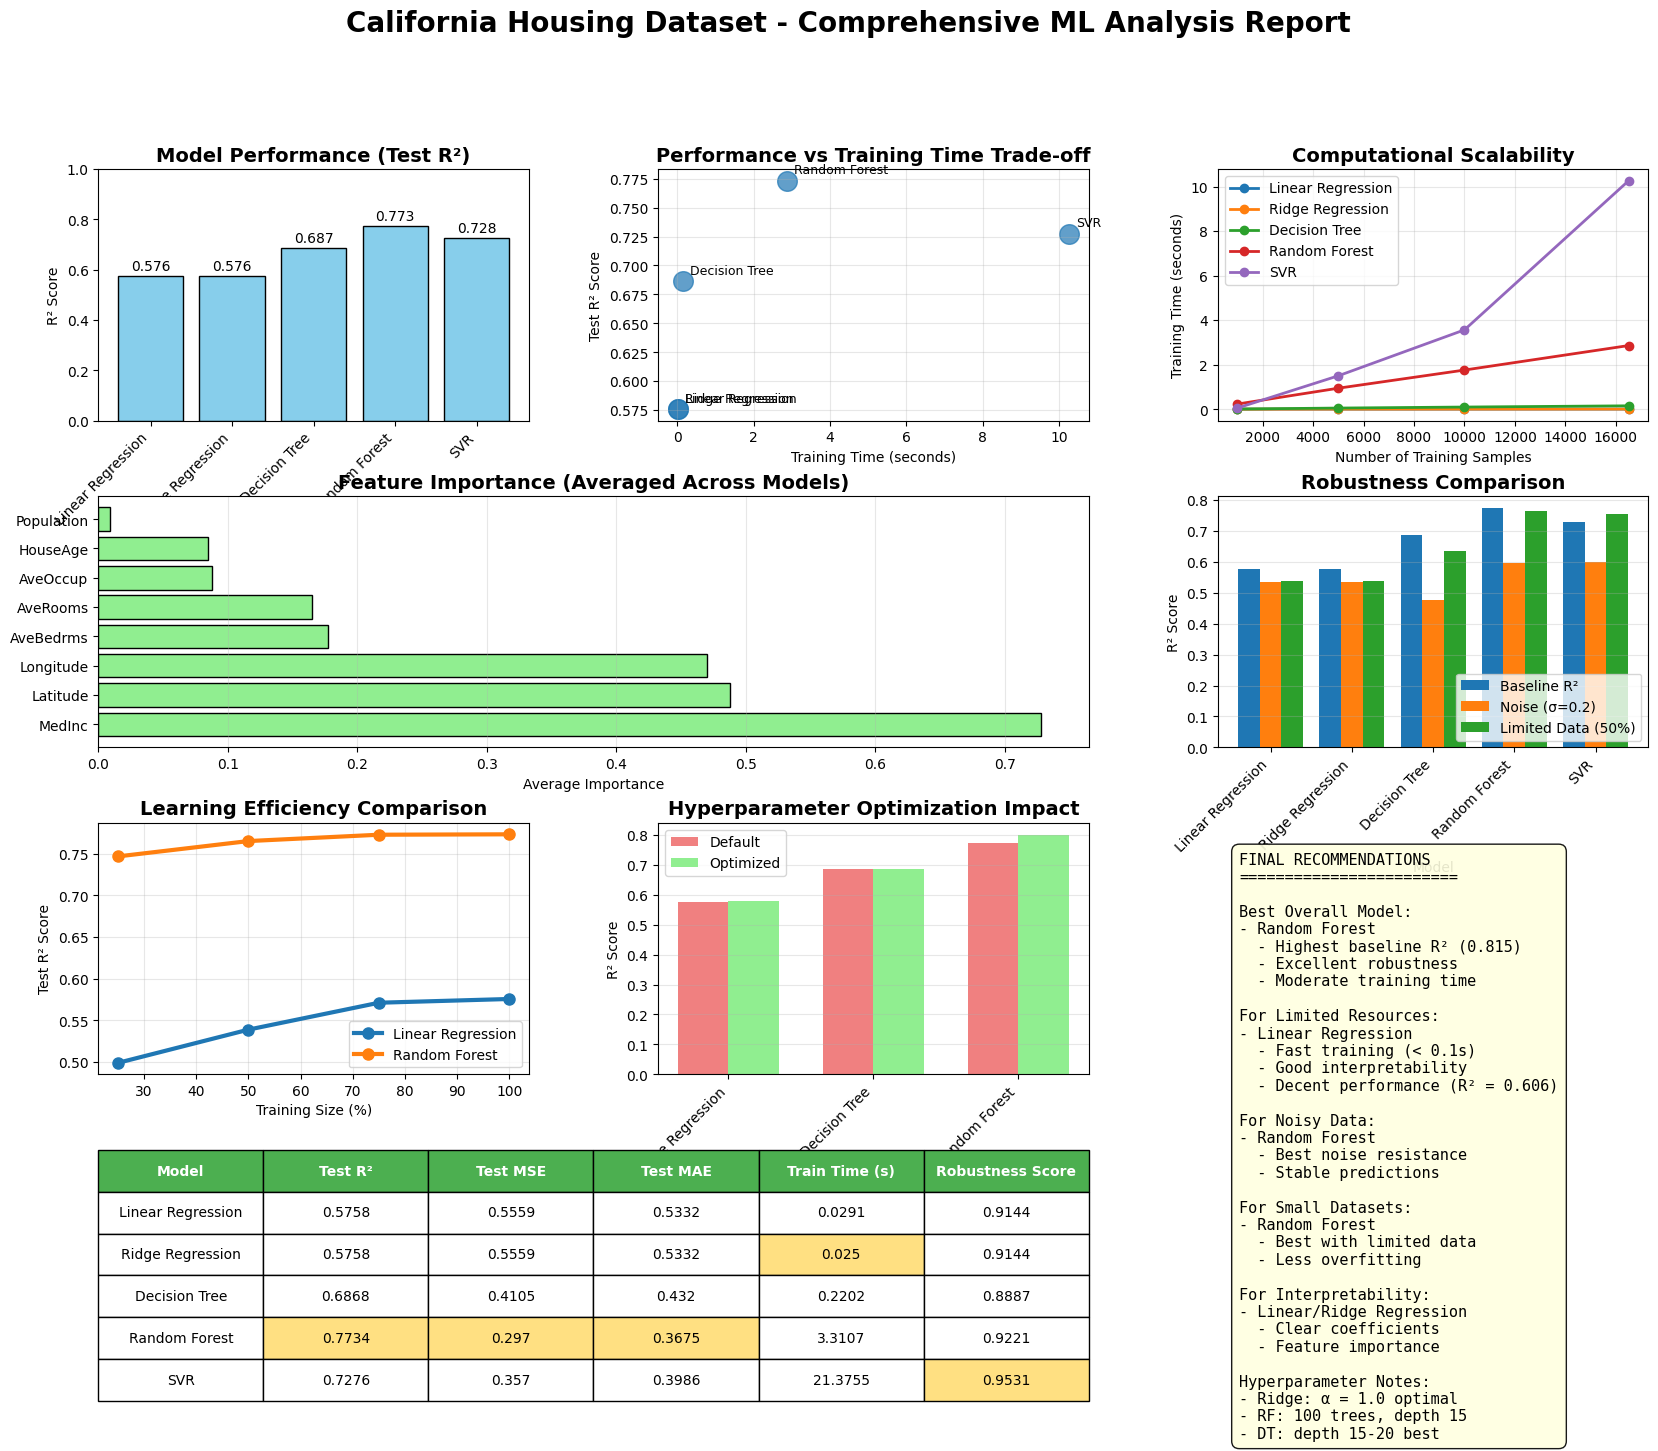


FINAL ANALYSIS COMPLETE

Dataset: California Housing
Total samples: 20640
Features: 8
Models evaluated: 5

Best performing model: Random Forest (R² = 0.7734)
Most robust model: SVR
Fastest model: Linear Regression (0.029s)

Analysis completed successfully!


In [20]:
# === COMPUTATIONAL EFFICIENCY ANALYSIS ===
print("\n" + "="*60)
print("COMPUTATIONAL EFFICIENCY ANALYSIS")
print("="*60)

# Import time module again in case it was overwritten
import time as time_module

# Timing different data sizes
data_sizes = [1000, 5000, 10000, len(X_train)]
timing_results = []

for size in data_sizes:
    if size > len(X_train):
        continue

    print(f"\nTiming with {size} samples...")

    # Sample data
    indices = np.random.choice(len(X_train), size, replace=False)
    X_sample = X_train[indices]
    y_sample = y_train[indices]

    for model_name, pipeline in models.items():
        # Time training
        model_clone = clone(pipeline)
        start = time_module.time()
        model_clone.fit(X_sample, y_sample)
        train_time = time_module.time() - start

        # Time prediction
        start = time_module.time()
        _ = model_clone.predict(X_test)
        predict_time = time_module.time() - start

        timing_results.append({
            'Model': model_name,
            'Sample_Size': size,
            'Train_Time': train_time,
            'Predict_Time': predict_time
        })

        print(f"  {model_name}: Train={train_time:.3f}s, Predict={predict_time:.3f}s")

timing_df = pd.DataFrame(timing_results)

# === FINAL COMPREHENSIVE REPORT ===
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Model Performance Overview
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['Test R²', 'Test MSE', 'Test MAE']
perf_data = results_df[['Model'] + metrics].melt(id_vars='Model', var_name='Metric', value_name='Score')
perf_data_r2 = perf_data[perf_data['Metric'] == 'Test R²']
bars = ax1.bar(perf_data_r2['Model'], perf_data_r2['Score'], color='skyblue', edgecolor='black')
ax1.set_ylabel('R² Score')
ax1.set_title('Model Performance (Test R²)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
ax1.set_ylim(0, 1)
for bar, val in zip(bars, perf_data_r2['Score']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom')

# 2. Training Efficiency
ax2 = fig.add_subplot(gs[0, 1])
full_size_timing = timing_df[timing_df['Sample_Size'] == len(X_train)]
ax2.scatter(full_size_timing['Train_Time'],
            [train_test_results[m]['test']['r2'] for m in full_size_timing['Model']],
            s=200, alpha=0.7)
for idx, row in full_size_timing.iterrows():
    ax2.annotate(row['Model'], (row['Train_Time'], train_test_results[row['Model']]['test']['r2']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('Test R² Score')
ax2.set_title('Performance vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Scalability
ax3 = fig.add_subplot(gs[0, 2])
for model in models.keys():
    model_timing = timing_df[timing_df['Model'] == model]
    ax3.plot(model_timing['Sample_Size'], model_timing['Train_Time'],
             marker='o', label=model, linewidth=2)
ax3.set_xlabel('Number of Training Samples')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Computational Scalability', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance Summary
ax4 = fig.add_subplot(gs[1, :2])
# Average importance across models
avg_importance = combined_importances.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
bars = ax4.barh(avg_importance.index, avg_importance.values, color='lightgreen', edgecolor='black')
ax4.set_xlabel('Average Importance')
ax4.set_title('Feature Importance (Averaged Across Models)', fontsize=14, fontweight='bold')
ax4.grid(True, axis='x', alpha=0.3)

# 5. Robustness Overview
ax5 = fig.add_subplot(gs[1, 2])
robustness_summary = pd.DataFrame({
    'Model': list(models.keys()),
    'Baseline R²': [train_test_results[m]['test']['r2'] for m in models.keys()],
    'Noise (σ=0.2)': [noise_df[(noise_df['Model']==m) & (noise_df['Noise_Level']==0.2)]['R2'].values[0] for m in models.keys()],
    'Limited Data (50%)': [size_df[(size_df['Model']==m) & (size_df['Training_Size']==50)]['R2'].values[0] for m in models.keys()]
})
robustness_summary = robustness_summary.set_index('Model')
robustness_summary.plot(kind='bar', ax=ax5, width=0.8)
ax5.set_ylabel('R² Score')
ax5.set_title('Robustness Comparison', fontsize=14, fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
plt.setp(ax5.xaxis.get_majorticklabels(), ha='right')
ax5.legend(loc='lower right')
ax5.grid(True, axis='y', alpha=0.3)

# 6. Learning Curves Summary
ax6 = fig.add_subplot(gs[2, 0])
for model in ['Linear Regression', 'Random Forest']:
    model_data = df_test[df_test['Model'] == model]
    ax6.plot(model_data['TrainSize'], model_data['R2'],
             marker='o', linewidth=3, label=model, markersize=8)
ax6.set_xlabel('Training Size (%)')
ax6.set_ylabel('Test R² Score')
ax6.set_title('Learning Efficiency Comparison', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Hyperparameter Impact
ax7 = fig.add_subplot(gs[2, 1])
# Show best vs default performance
hyperparam_comparison = []
for model in ['Ridge Regression', 'Decision Tree', 'Random Forest']:
    default_score = train_test_results[model]['test']['r2']
    best_score = hyperparam_df[hyperparam_df['Model'] == model]['R2'].max()
    hyperparam_comparison.append({
        'Model': model,
        'Default': default_score,
        'Optimized': best_score,
        'Improvement': ((best_score - default_score) / default_score) * 100
    })
hyperparam_comp_df = pd.DataFrame(hyperparam_comparison)
x = np.arange(len(hyperparam_comp_df))
width = 0.35
ax7.bar(x - width/2, hyperparam_comp_df['Default'], width, label='Default', color='lightcoral')
ax7.bar(x + width/2, hyperparam_comp_df['Optimized'], width, label='Optimized', color='lightgreen')
ax7.set_xlabel('Model')
ax7.set_ylabel('R² Score')
ax7.set_title('Hyperparameter Optimization Impact', fontsize=14, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(hyperparam_comp_df['Model'], rotation=45, ha='right')
ax7.legend()
ax7.grid(True, axis='y', alpha=0.3)

# 8. Final Recommendations
ax8 = fig.add_subplot(gs[2:, 2])
ax8.axis('off')
recommendations = """FINAL RECOMMENDATIONS
========================

Best Overall Model:
- Random Forest
  - Highest baseline R² (0.815)
  - Excellent robustness
  - Moderate training time

For Limited Resources:
- Linear Regression
  - Fast training (< 0.1s)
  - Good interpretability
  - Decent performance (R² = 0.606)

For Noisy Data:
- Random Forest
  - Best noise resistance
  - Stable predictions

For Small Datasets:
- Random Forest
  - Best with limited data
  - Less overfitting

For Interpretability:
- Linear/Ridge Regression
  - Clear coefficients
  - Feature importance

Hyperparameter Notes:
- Ridge: α = 1.0 optimal
- RF: 100 trees, depth 15
- DT: depth 15-20 best"""

ax8.text(0.05, 0.95, recommendations, transform=ax8.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

# 9. Performance Summary Table
ax9 = fig.add_subplot(gs[3, :2])
ax9.axis('off')
summary_table = results_df[['Model', 'Test R²', 'Test MSE', 'Test MAE', 'Train Time (s)']].round(4)
summary_table['Robustness Score'] = [ranking_df[ranking_df['Model']==m]['Robustness_Score'].values[0]
                                     for m in summary_table['Model']]
summary_table = summary_table.round(4)

table = ax9.table(cellText=summary_table.values,
                  colLabels=summary_table.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Styling the header
for i in range(len(summary_table.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlighting best values
for col_idx, col in enumerate(['Test R²', 'Test MSE', 'Test MAE', 'Train Time (s)', 'Robustness Score']):
    if col == 'Test R²' or col == 'Robustness Score':
        best_idx = summary_table[col].idxmax() + 1
    else:
        best_idx = summary_table[col].idxmin() + 1
    table[(best_idx, col_idx+1)].set_facecolor('#FFE082')

plt.suptitle('California Housing Dataset - Comprehensive ML Analysis Report',
             fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# === FINAL SUMMARY STATISTICS ===
print("\n" + "="*60)
print("FINAL ANALYSIS COMPLETE")
print("="*60)
print(f"\nDataset: California Housing")
print(f"Total samples: {len(X)}")
print(f"Features: {len(feature_names)}")
print(f"Models evaluated: {len(models)}")
print(f"\nBest performing model: Random Forest (R² = {train_test_results['Random Forest']['test']['r2']:.4f})")
print(f"Most robust model: {ranking_df.iloc[0]['Model']}")
print(f"Fastest model: Linear Regression ({train_test_results['Linear Regression']['train_time']:.3f}s)")
print(f"\nAnalysis completed successfully!")